In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from prophet import Prophet
from statistics import mode
from pandas.api.types import CategoricalDtype

# Loading Data

In [99]:
csv_data_path = "./data/sales_data_sample.csv"
json_data_path = "./data/sales_data_sample.json"
csv_file = pd.read_csv(csv_data_path) 
json_data = pd.read_json(json_data_path)
df = [csv_file, json_data]
df = pd.concat(df)
df.head(2)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.0,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.9,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small


# Data Pre-Processing

In [100]:
df = df.drop(columns=["ADDRESSLINE1","ADDRESSLINE2","STATE","TERRITORY","POSTALCODE", "ORDERLINENUMBER", "QTR_ID", "MSRP", "PHONE","CONTACTLASTNAME","CONTACTFIRSTNAME"])
null_count = df.isnull().sum()
null_count


ORDERNUMBER        0
QUANTITYORDERED    0
PRICEEACH          0
SALES              0
ORDERDATE          0
STATUS             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
PRODUCTCODE        0
CUSTOMERNAME       0
CITY               0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [101]:
df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,SALES,ORDERDATE,STATUS,MONTH_ID,YEAR_ID,PRODUCTLINE,PRODUCTCODE,CUSTOMERNAME,CITY,COUNTRY,DEALSIZE
0,10107,30,95.70,2871.00,2/24/2003 0:00,Shipped,2,2003,Motorcycles,S10_1678,Land of Toys Inc.,NYC,USA,Small
1,10121,34,81.35,2765.90,5/7/2003 0:00,Shipped,5,2003,Motorcycles,S10_1678,Reims Collectables,Reims,France,Small
2,10134,41,94.74,3884.34,7/1/2003 0:00,Shipped,7,2003,Motorcycles,S10_1678,Lyon Souveniers,Paris,France,Medium
3,10145,45,83.26,3746.70,8/25/2003 0:00,Shipped,8,2003,Motorcycles,S10_1678,Toys4GrownUps.com,Pasadena,USA,Medium
4,10159,49,100.00,5205.27,10/10/2003 0:00,Shipped,10,2003,Motorcycles,S10_1678,Corporate Gift Ideas Co.,San Francisco,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,10350,20,100.00,2244.40,12/2/2004 0:00,Shipped,12,2004,Ships,S72_3212,Euro Shopping Channel,Madrid,Spain,Small
819,10373,29,100.00,3978.51,1/31/2005 0:00,Shipped,1,2005,Ships,S72_3212,"Oulu Toy Supplies, Inc.",Oulu,Finland,Medium
820,10386,43,100.00,5417.57,3/1/2005 0:00,Resolved,3,2005,Ships,S72_3212,Euro Shopping Channel,Madrid,Spain,Medium
821,10397,34,62.24,2116.16,3/28/2005 0:00,Shipped,3,2005,Ships,S72_3212,Alpha Cognac,Toulouse,France,Small


In [102]:
order_date = df["ORDERDATE"]
order_date = pd.Series([el.split(" ")[0] for el in order_date])
df["ORDERDATE"] = pd.to_datetime(order_date)

df['year_month'] = df["ORDERDATE"].dt.to_period('M') 

# Analytics

### country/total sales

highest country shares:
COUNTRY
USA       3627982.83
Spain     1215686.92
France    1110916.52
Name: total_sales, dtype: float64
lowest country shares:
COUNTRY
Belgium        108412.62
Philippines     94015.73
Ireland         57756.43
Name: total_sales, dtype: float64


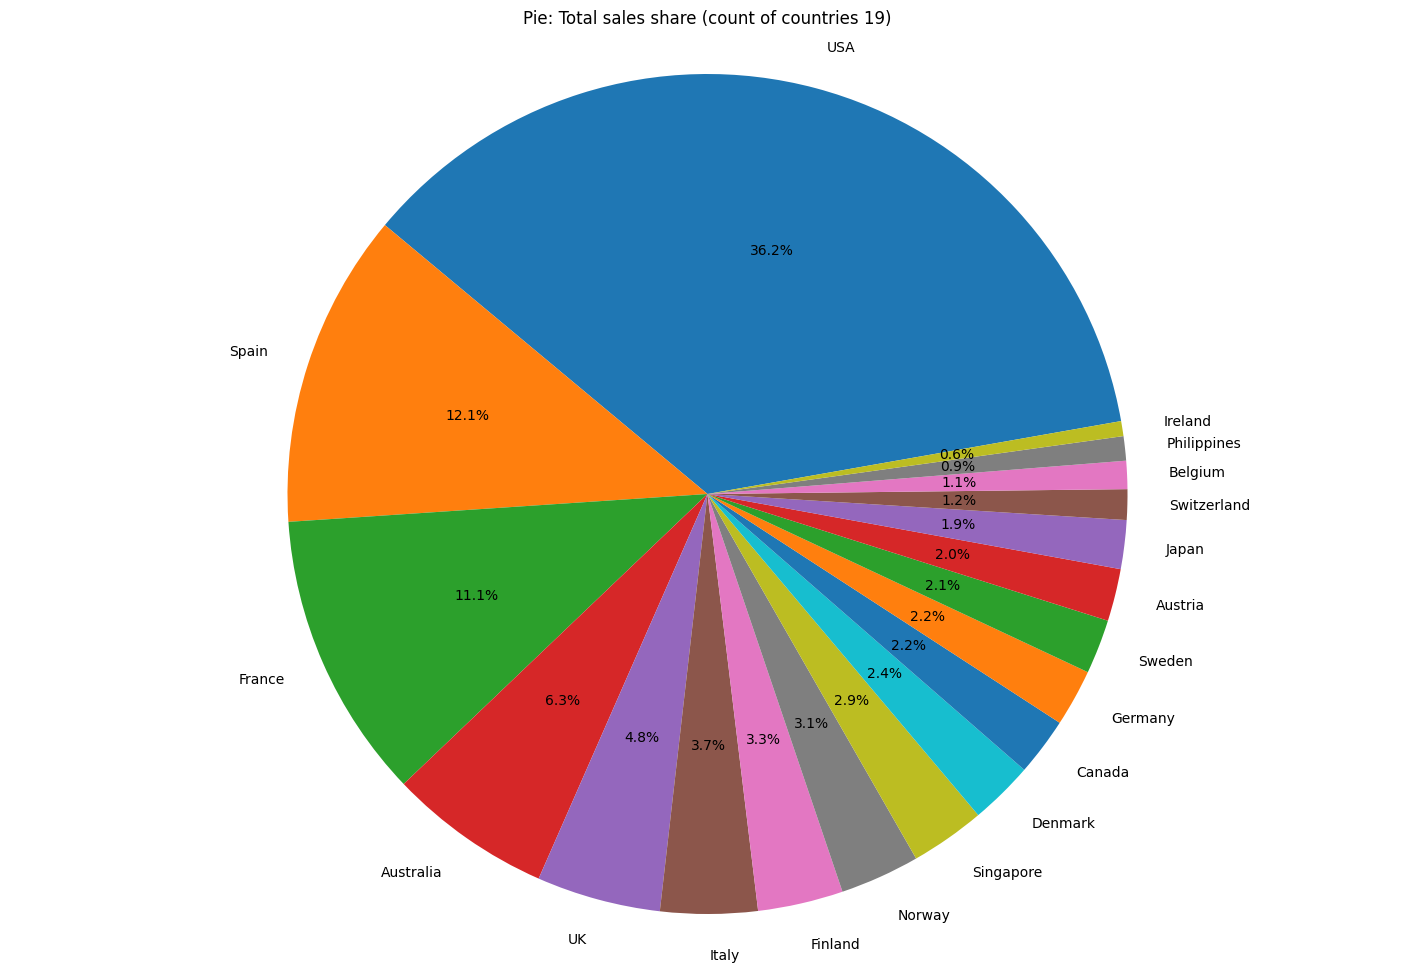

In [103]:
# country/sales relationship
country_aggregated_data = df.groupby('COUNTRY').agg(
    total_sales=('SALES', 'sum'), clients_count=('CUSTOMERNAME', 'count')
    ).sort_values('total_sales', ascending=False)

positions = np.arange(len(country_aggregated_data))
heights = country_aggregated_data['total_sales']
labels = country_aggregated_data.index.astype(str)

highest_countries = country_aggregated_data['total_sales'].head(3)
lowest_countries = country_aggregated_data['total_sales'][-3:]

print(f"highest country shares:\n{highest_countries}")
print(f"lowest country shares:\n{lowest_countries}")

fig, ax = plt.subplots(figsize=(18, 12))
ax.pie(heights, labels=labels, autopct='%1.1f%%', startangle=10)
ax.set_title('Pie: Total sales share (count of countries {})'.format(len(country_aggregated_data)))
ax.axis('equal')

plt.show()

### TOTAL monthly sales

highest month: 
          total_sales  clients_count
MONTH_ID                            
1           785874.44            229
lowest month: 
total_sales      634679.12
clients_count       180.00
Name: 12, dtype: float64


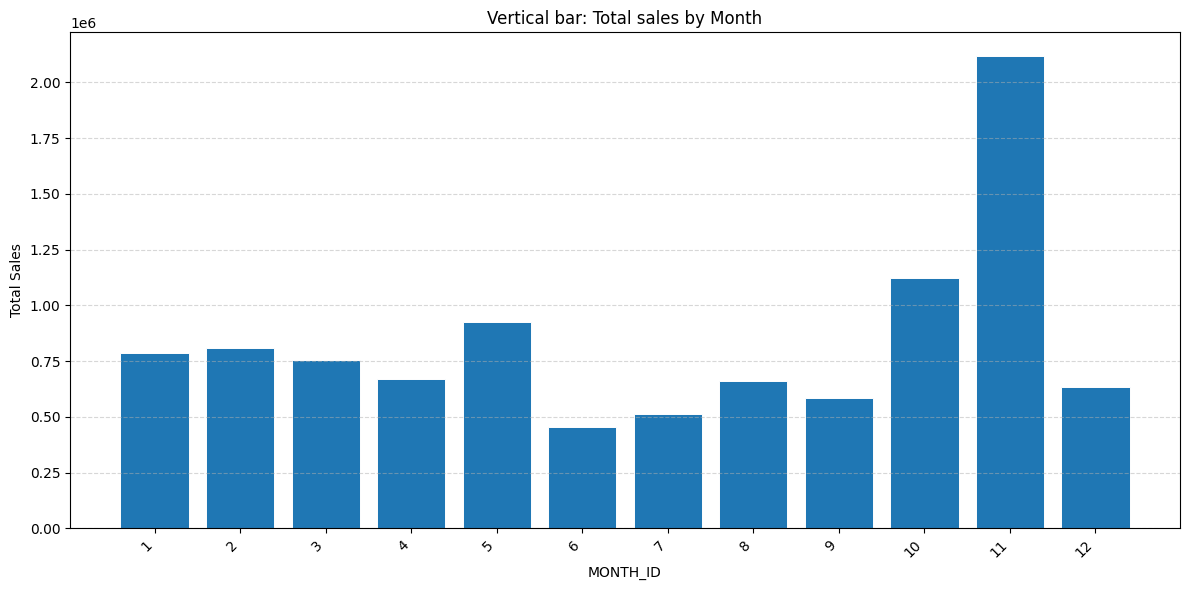

In [104]:
# month/sales relationship
month_id_aggregated_data = df.groupby(['MONTH_ID']).agg(
    total_sales=('SALES', 'sum'),
    clients_count=('CUSTOMERNAME', 'count')
)

highest_month = month_id_aggregated_data.head(1)
lowest_month = month_id_aggregated_data.iloc[-1]
print(f"highest month: \n{highest_month}")
print(f"lowest month: \n{lowest_month}")


positions = np.arange(len(month_id_aggregated_data))
heights = month_id_aggregated_data['total_sales']
labels = month_id_aggregated_data.index.astype(str)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(positions, heights, color='C0', edgecolor='white', linewidth=0.7)
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('MONTH_ID')
ax.set_ylabel('Total Sales')
ax.set_title('Vertical bar: Total sales by Month')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

            total_sales
year_month             
2003-01       138671.06
2003-02       122266.76
2003-03       209464.19
2003-04       170618.90
2003-05       232262.09
2003-06       137318.62
2003-07       226187.93
2003-08       168566.60
2003-09       316477.71
2003-10       600615.59
2003-11      1118936.38
2003-12       317627.49
2004-01       338620.72
2004-02       301665.94
2004-03       204561.31
2004-04       228011.98
2004-05       239101.57
2004-06       281592.76
2004-07       329298.42
2004-08       480724.10
2004-09       309279.07
2004-10       550846.08
2004-11      1014947.80
2004-12       286289.53
2005-01       334616.80
2005-02       339163.95
2005-03       300106.67
2005-04       250303.00
2005-05       484485.83
29


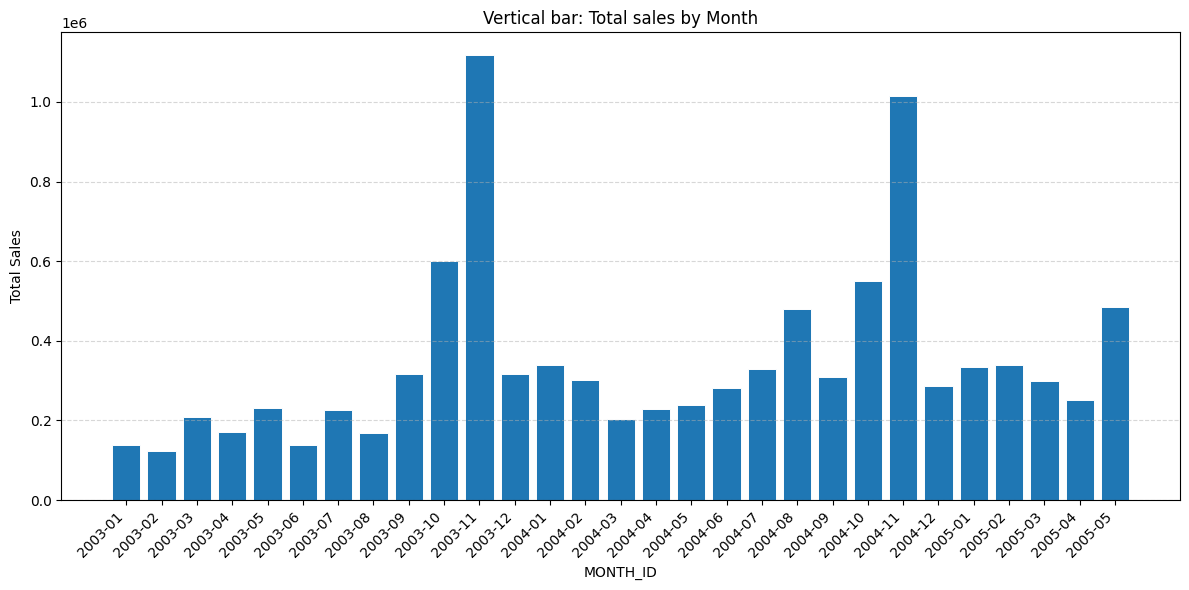

In [105]:
monthly_sales = df.groupby('year_month').agg(
    total_sales=('SALES',"sum")
)

print(monthly_sales)
print(len(monthly_sales))

positions = np.arange(len(monthly_sales))
heights = monthly_sales['total_sales']
labels = monthly_sales.index.astype(str)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(positions, heights, color='C0', edgecolor='white', linewidth=0.7)
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('MONTH_ID')
ax.set_ylabel('Total Sales')
ax.set_title('Vertical bar: Total sales by Month')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### total sales per each product

             total_product_sales
PRODUCTCODE                     
S18_3232               288245.42
S10_1949               191073.03
S10_4698               170401.07
S12_1108               168585.32
S18_2238               154623.95


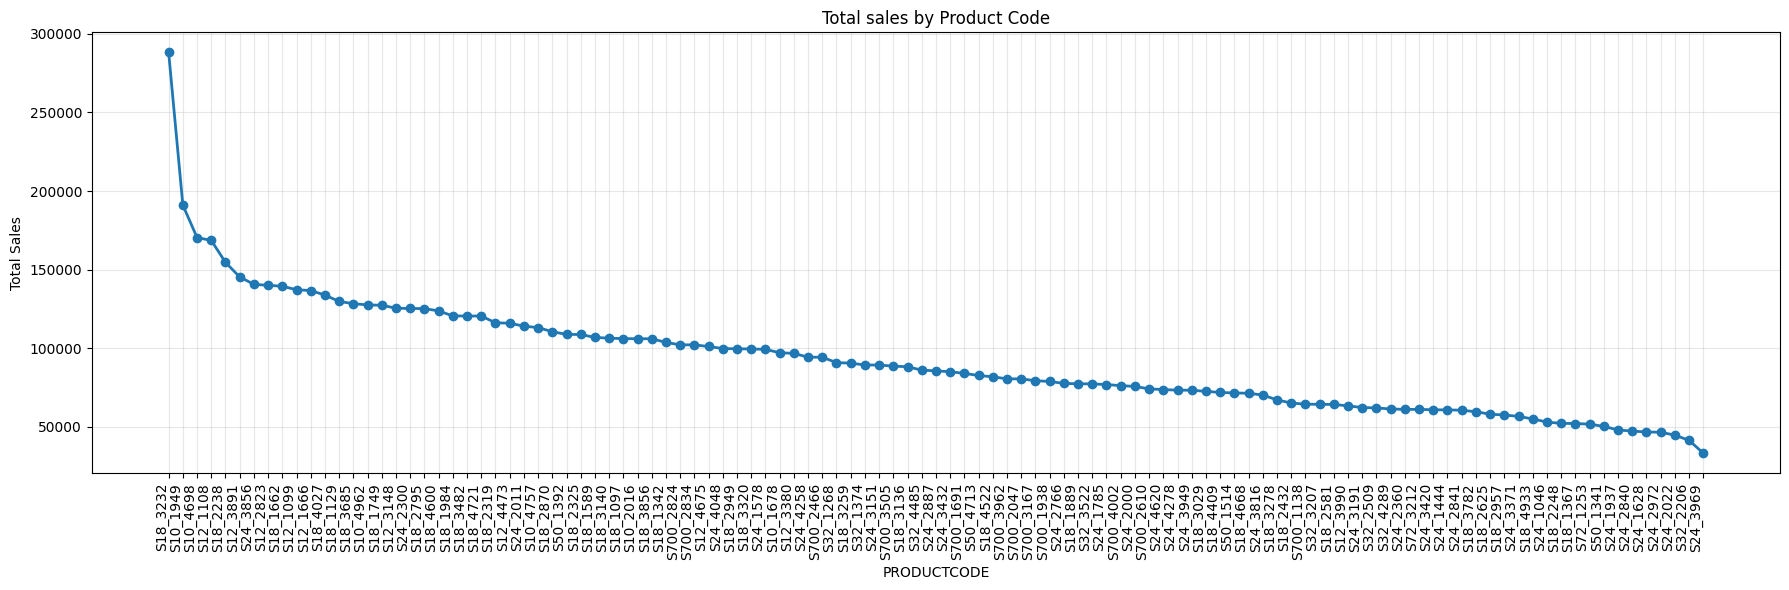

In [106]:
products_performance = df.groupby("PRODUCTCODE").agg(
    total_product_sales=("SALES", "sum")
).sort_values('total_product_sales', ascending=False)

print(products_performance.head())

products_performance = products_performance.reset_index()

positions = np.arange(len(products_performance))
heights = products_performance['total_product_sales']
labels = products_performance['PRODUCTCODE']

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(positions, heights, marker='o', linestyle='-', linewidth=2, markersize=6)
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=90, ha='right')
ax.set_xlabel('PRODUCTCODE')
ax.set_ylabel('Total Sales')
ax.set_title('Total sales by Product Code')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### dominant deal size for each country

DEALSIZE      COUNTRY  Large  Medium  Small
0           Australia      7      86     92
1             Austria      4      29     22
2             Belgium      0      15     18
3              Canada      1      33     36
4             Denmark      6      31     26
5             Finland      5      46     41
6              France     21     149    144
7             Germany      4      30     28
8             Ireland      2       6      8
9               Italy      7      44     62
10              Japan      3      21     28
11             Norway      5      42     38
12        Philippines      1      14     11
13          Singapore      4      38     37
14              Spain     17     171    154
15             Sweden      2      31     24
16        Switzerland      0      22      9
17                 UK      4      71     69
18                USA     64     505    435


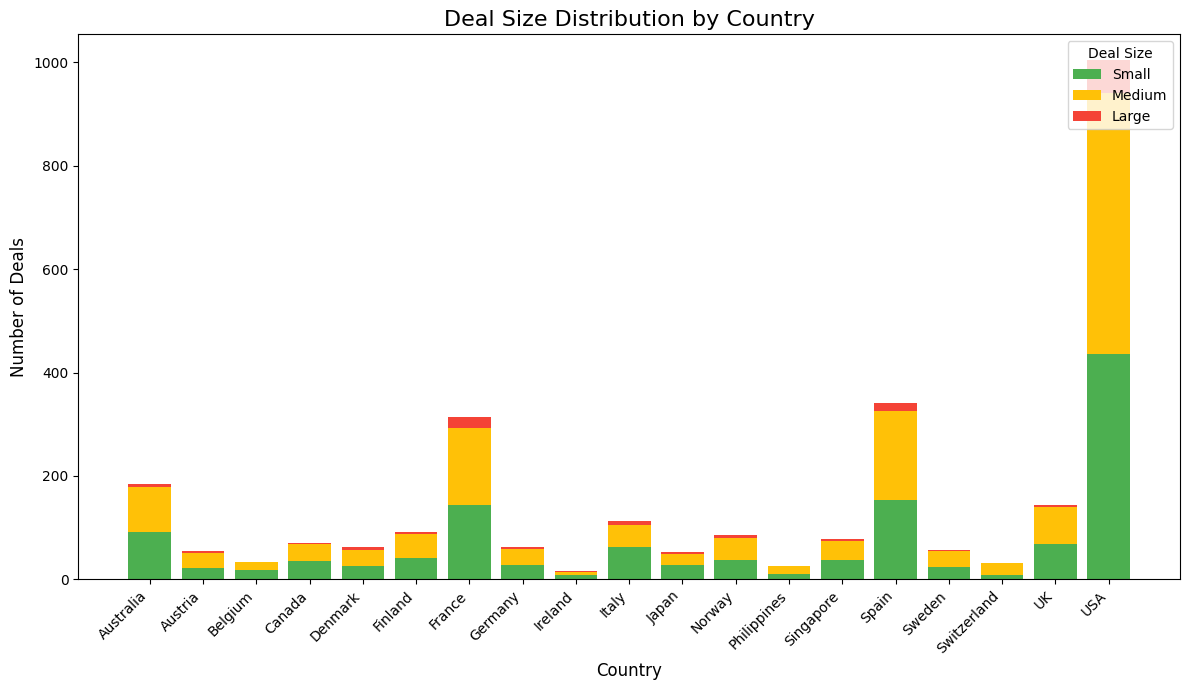

In [107]:
deal_sizes = pd.crosstab(df['COUNTRY'], df['DEALSIZE'])
deal_sizes = deal_sizes.reset_index()

print(deal_sizes)
deal_sizes_df = deal_sizes.set_index('COUNTRY')

deal_sizes_df['Medium_Bottom'] = deal_sizes_df['Small']
deal_sizes_df['Large_Bottom'] = deal_sizes_df['Small'] + deal_sizes_df['Medium']

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(deal_sizes_df.index, deal_sizes_df['Small'], label='Small', color='#4CAF50')
ax.bar(deal_sizes_df.index, deal_sizes_df['Medium'], bottom=deal_sizes_df['Medium_Bottom'], label='Medium', color='#FFC107')
ax.bar(deal_sizes_df.index, deal_sizes_df['Large'], bottom=deal_sizes_df['Large_Bottom'], label='Large', color='#F44336')
ax.set_title('Deal Size Distribution by Country', fontsize=16)
ax.set_ylabel('Number of Deals', fontsize=12)
ax.set_xlabel('Country', fontsize=12)
ax.legend(title='Deal Size', loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [108]:
dominant_deal_size = deal_sizes_df[['Large', 'Medium', 'Small']].idxmax(axis=1)
countries_classified = dominant_deal_size.groupby(dominant_deal_size).groups
for key in countries_classified:
    print(f"{key}: {list(countries_classified[key])}")

Medium: ['Austria', 'Denmark', 'Finland', 'France', 'Germany', 'Norway', 'Philippines', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'UK', 'USA']
Small: ['Australia', 'Belgium', 'Canada', 'Ireland', 'Italy', 'Japan']


In [109]:
countries = df['COUNTRY'].unique()
popular_products = {}
for country in countries:
    popular_products[country] = df[df['COUNTRY']== country].groupby("PRODUCTCODE").agg(total_sales=("SALES",'sum')).sort_values(by="total_sales", ascending=False)
print(popular_products)
for key, product_df in popular_products.items():
    product_df = product_df.reset_index()
    top_5 = list(product_df['PRODUCTCODE'][:5])
    filter_list = []
    for p in top_5:
        product_name = df[df['PRODUCTCODE'] == p]["PRODUCTLINE"].head(1)
        product_name.reset_index(drop=True)
        filter_list.append(list(product_name)[0])
    print(f"most popular product in {key} is {mode(filter_list)}")
    

{'USA':              total_sales
PRODUCTCODE             
S18_3232        80984.25
S10_4698        79092.67
S10_1949        75354.44
S18_2238        74791.30
S12_2823        73865.04
...                  ...
S72_3212        14476.37
S24_3371        14066.65
S24_2022        13159.74
S12_3990        11694.54
S24_1937        10927.09

[109 rows x 1 columns], 'France':              total_sales
PRODUCTCODE             
S12_2823        32469.62
S18_3232        32221.76
S50_4713        25164.70
S10_4698        22818.80
S700_2824       20839.24
...                  ...
S18_3136         2232.62
S24_2840         1751.88
S18_2957         1559.04
S24_3816         1514.52
S24_3969         1185.30

[108 rows x 1 columns], 'Norway':              total_sales
PRODUCTCODE             
S18_3685        12231.96
S24_3856        11585.25
S18_1129        11335.94
S18_1984        10774.12
S18_3232        10336.41
...                  ...
S24_4278         1491.00
S24_2360         1346.40
S18_1367         1345.

# Trends

### utils

In [110]:
def assess_trend_for_item(df: pd.DataFrame, threshold: float = 0.10) -> str:
    df["sales_next_year"] = df["total_sales"].shift(-12)

    df_compare = df.dropna(subset=["sales_next_year"])

    if df_compare.empty:
        return "not enough data"

    epsilon = 1e-6
    change_pct = (df_compare["sales_next_year"] - df_compare["total_sales"]) / (
        df_compare["total_sales"] + epsilon
    )

    def classify_change(pct_change):
        if pct_change > threshold:
            return "rising"
        elif pct_change < -threshold:
            return "falling"
        else:
            return "stable"

    df_compare["trend_class"] = change_pct.apply(classify_change)

    class_counts = df_compare["trend_class"].value_counts()
    total_comparisons = len(df_compare)

    if class_counts.empty:
        return "not enough data"

    most_frequent_class = class_counts.index[0]
    frequency_of_mode = class_counts.iloc[0]

    if frequency_of_mode / total_comparisons < 0.5:
        if len(class_counts) > 1 and (class_counts.iloc[0] - class_counts.iloc[1] <= 1):
            return "unstable"

    return most_frequent_class


def analyze_sales_trends(data_dict: dict) -> dict:
    results = {}
    for item_key, df in data_dict.items():
        df["total_sales"] = pd.to_numeric(df["total_sales"], errors="coerce")
        trend = assess_trend_for_item(df)
        results[item_key] = trend
    return results


### the sales performance trend for each country

{'USA':    year_month  total_sales
0     2003-01     30582.79
1     2003-02     38925.30
2     2003-03     83046.08
3     2003-04     32594.01
4     2003-05     49105.49
5     2003-06     84536.39
6     2003-07    103882.93
7     2003-08    125017.48
8     2003-09    100253.58
9     2003-10    233154.67
10    2003-11    361840.40
11    2003-12    178624.78
12    2004-01     90181.37
13    2004-02     83329.98
14    2004-03     73653.56
15    2004-04     48052.91
16    2004-05    128265.79
17    2004-06     88947.96
18    2004-07    104106.89
19    2004-08    223386.99
20    2004-09     54866.01
21    2004-10    166562.03
22    2004-11    403552.43
23    2004-12    109263.29
24    2005-01    145457.57
25    2005-02    121495.85
26    2005-03    121097.49
27    2005-04    114599.48
28    2005-05    129599.33, 'France':    year_month  total_sales
0     2003-01      5859.78
1     2003-02         0.00
2     2003-03         0.00
3     2003-04     28231.27
4     2003-05     79104.68
5     200

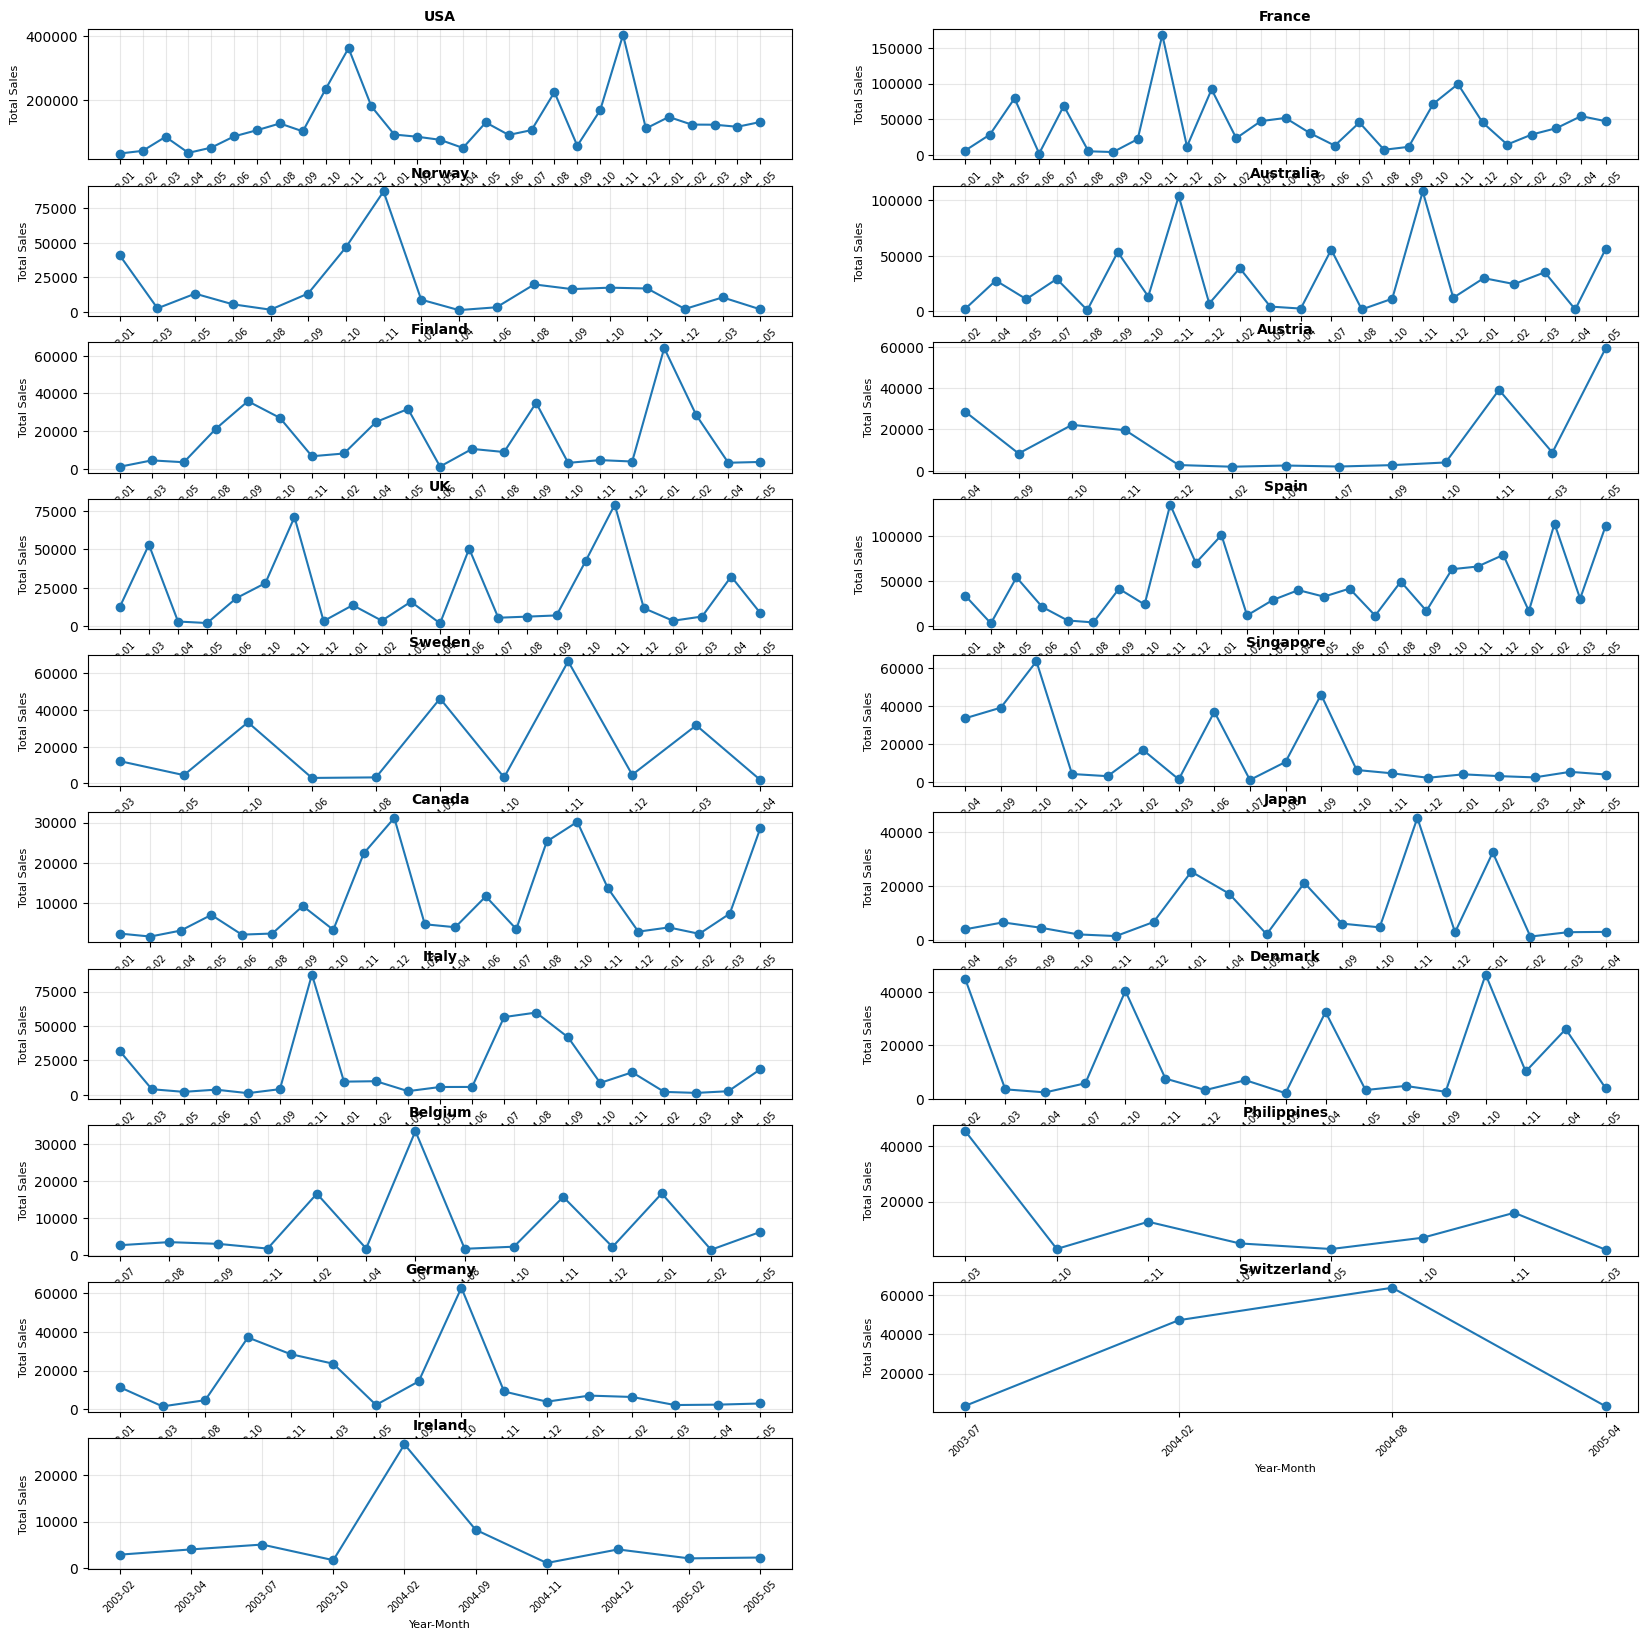

In [111]:
all_year_months = df['year_month'].unique()

countries = df['COUNTRY'].unique()
n_countries = len(countries)

n_cols = 2
n_rows = (n_countries + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

countries_performance_record = {}

for idx, country in enumerate(countries):
    ax = axes[idx]
    
    country_data = df[df['COUNTRY'] == country].groupby('year_month').agg(
        total_sales=("SALES",'sum')
    )
    
    complete_data = pd.DataFrame({'year_month': all_year_months})
    complete_data = complete_data.merge(country_data, on='year_month', how='left')
    complete_data['total_sales'] = complete_data['total_sales'].fillna(0)
    complete_data = complete_data.sort_values('year_month').reset_index(drop=True)
    
    countries_performance_record[country] = complete_data

    
    ax.plot(country_data.index.astype(str), country_data.values, marker='o', linestyle='-', color='C0')
    ax.set_title(country, fontsize=10, fontweight='bold')
    ax.set_xlabel('Year-Month', fontsize=8)
    ax.set_ylabel('Total Sales', fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.grid(True, alpha=0.3)

for idx in range(n_countries, len(axes)):
    axes[idx].set_visible(False)

print(countries_performance_record)

### the sales performance trend for each product

In [112]:
products = df['PRODUCTCODE'].unique()
n_products = len(products)


products_performance_record = {}
for product in products:
    product_data = df[df['PRODUCTCODE'] == product].groupby('year_month').agg(total_sales=('SALES', 'sum')).reset_index()
    
    complete_data = pd.DataFrame({'year_month': all_year_months})
    complete_data = complete_data.merge(product_data, on='year_month', how='left')
    complete_data['total_sales'] = complete_data['total_sales'].fillna(0)
    complete_data = complete_data.sort_values('year_month').reset_index(drop=True)
    
    products_performance_record[product] = complete_data

print(products_performance_record)

{'S10_1678':    year_month  total_sales
0     2003-01         0.00
1     2003-02      2871.00
2     2003-03         0.00
3     2003-04         0.00
4     2003-05      2765.90
5     2003-06         0.00
6     2003-07      3884.34
7     2003-08      3746.70
8     2003-09         0.00
9     2003-10      8685.03
10    2003-11      8010.09
11    2003-12      2168.54
12    2004-01      4708.44
13    2004-02      3965.66
14    2004-03         0.00
15    2004-04      2333.12
16    2004-05      3188.64
17    2004-06      3676.76
18    2004-07      4177.35
19    2004-08      4099.68
20    2004-09      2597.39
21    2004-10      4394.38
22    2004-11     16492.11
23    2004-12      1451.00
24    2005-01         0.00
25    2005-02       733.11
26    2005-03      3207.12
27    2005-04      2434.56
28    2005-05      7516.08, 'S10_1949':    year_month  total_sales
0     2003-01      5404.62
1     2003-02         0.00
2     2003-03      7209.11
3     2003-04         0.00
4     2003-05      7329.06
5 

### visulaizing an example of product sales over time relationship

  year_month  total_sales
0    2003-01         0.00
1    2003-02      3896.49
2    2003-03         0.00


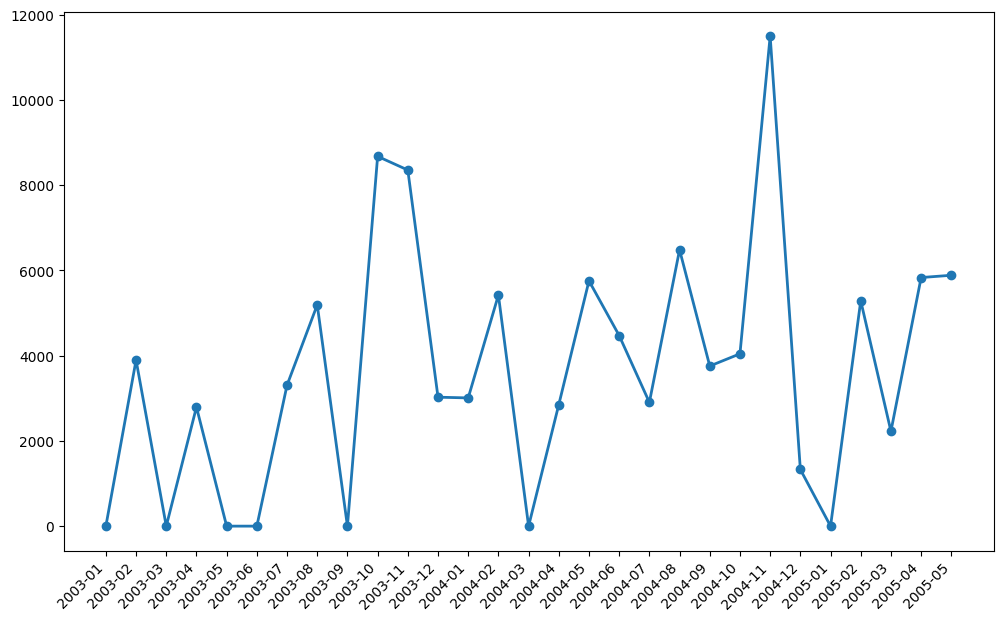

In [113]:
target = products[2]
target_column = products_performance_record[target]
print(target_column.head(3))
positions = np.arange(len(target_column))
heights = target_column['total_sales']
labels = target_column['year_month']
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(positions, heights, marker='o', linestyle='-', linewidth=2, markersize=6)
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.show()

### analyze products sales performance

In [114]:
results = analyze_sales_trends(products_performance_record)
assessment_record = {}
for key, value in results.items():
    if value not in assessment_record.keys():
        assessment_record[value] = []
        assessment_record[value].append(key)
    else:
        assessment_record[value].append(key)
for key in assessment_record.keys():
    print(f"the number of {key} products is {len(assessment_record[key])}")

C:\Users\alkrd\AppData\Local\Temp\ipykernel_7544\706891084.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare["trend_class"] = change_pct.apply(classify_change)
C:\Users\alkrd\AppData\Local\Temp\ipykernel_7544\706891084.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare["trend_class"] = change_pct.apply(classify_change)
C:\Users\alkrd\AppData\Local\Temp\ipykernel_7544\706891084.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

the number of rising products is 73
the number of falling products is 8
the number of unstable products is 28


C:\Users\alkrd\AppData\Local\Temp\ipykernel_7544\706891084.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare["trend_class"] = change_pct.apply(classify_change)
C:\Users\alkrd\AppData\Local\Temp\ipykernel_7544\706891084.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare["trend_class"] = change_pct.apply(classify_change)
C:\Users\alkrd\AppData\Local\Temp\ipykernel_7544\706891084.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

# Sales Forecasting Model Training

In [115]:
training_data = df[["ORDERDATE", "QUANTITYORDERED", "SALES"]].copy().sort_values(by='ORDERDATE')
training_data = training_data.groupby('ORDERDATE').agg(
    orders_quantity=('QUANTITYORDERED', 'sum'),
    total_sales=('SALES', 'sum')
)
training_data.index.name = 'date'
training_data

,orders_quantity,total_sales
date,,
2003-01-06,146,14981.83
2003-01-09,177,14317.39
2003-01-10,151,12064.05
2003-01-29,577,51538.20
2003-01-31,454,45769.59
...,...,...
2005-05-13,425,43856.80
2005-05-17,836,87959.65
2005-05-29,702,60340.94


In [116]:
split_date = pd.to_datetime("2005-01-01")
train_subset = training_data.loc[training_data.index < split_date].copy()
test_subset = training_data.loc[training_data.index > split_date].copy()

In [ ]:
Pmodel_train_subset = train_subset.reset_index().rename(columns={'date':'ds','total_sales':'y'})
    
Pmodel_train_subset['orders_quantity'] = train_subset.values

Pmodel_train_subset.head()
model = Prophet()
model.add_regressor("orders_quantity")

model.fit(Pmodel_train_subset)


13:07:26 - cmdstanpy - INFO - Chain [1] start processing
13:07:26 - cmdstanpy - INFO - Chain [1] done processing


In [119]:
Pmodel_test_subset = test_subset.reset_index().rename(columns={
        'date':'ds',
        'total_sales':'y'
    })

Pmodel_test_subset['orders_quantity'] = test_subset['orders_quantity'].values

forecasting_result = model.predict(Pmodel_test_subset)
forecasting_result.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,orders_quantity,orders_quantity_lower,orders_quantity_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-05,39651.754109,11336.608507,21986.386550,39651.754109,39651.754109,-23283.134001,-23283.134001,-23283.134001,-22246.885819,...,-22246.885819,-22246.885819,-22246.885819,-1036.248182,-1036.248182,-1036.248182,0.0,0.0,0.0,16368.620108
1,2005-01-06,39636.980601,51907.513666,62821.603742,39636.980601,39636.980601,17834.558206,17834.558206,17834.558206,17624.853656,...,17624.853656,17624.853656,17624.853656,209.704550,209.704550,209.704550,0.0,0.0,0.0,57471.538807
2,2005-01-07,39622.207093,-365.680744,9836.616215,39620.918434,39622.905925,-34889.400029,-34889.400029,-34889.400029,-35673.083805,...,-35673.083805,-35673.083805,-35673.083805,783.683777,783.683777,783.683777,0.0,0.0,0.0,4732.807064
3,2005-01-10,39577.886569,6488.059155,16694.708304,39574.297479,39579.871306,-27804.902984,-27804.902984,-27804.902984,-27332.566874,...,-27332.566874,-27332.566874,-27332.566874,-472.336110,-472.336110,-472.336110,0.0,0.0,0.0,11772.983585
4,2005-01-12,39548.339554,53894.644944,64801.453469,39542.617329,39552.361120,19334.873244,19334.873244,19334.873244,20371.121426,...,20371.121426,20371.121426,20371.121426,-1036.248182,-1036.248182,-1036.248182,0.0,0.0,0.0,58883.212797


In [120]:
print(test_subset.head())
print(forecasting_result[['ds','yhat']].head())

            orders_quantity  total_sales
date                                    
2005-01-05              196     19128.38
2005-01-06              588     51918.86
2005-01-07               64      4719.80
2005-01-10              146     19828.02
2005-01-12              615     57220.81
          ds          yhat
0 2005-01-05  16368.620108
1 2005-01-06  57471.538807
2 2005-01-07   4732.807064
3 2005-01-10  11772.983585
4 2005-01-12  58883.212797


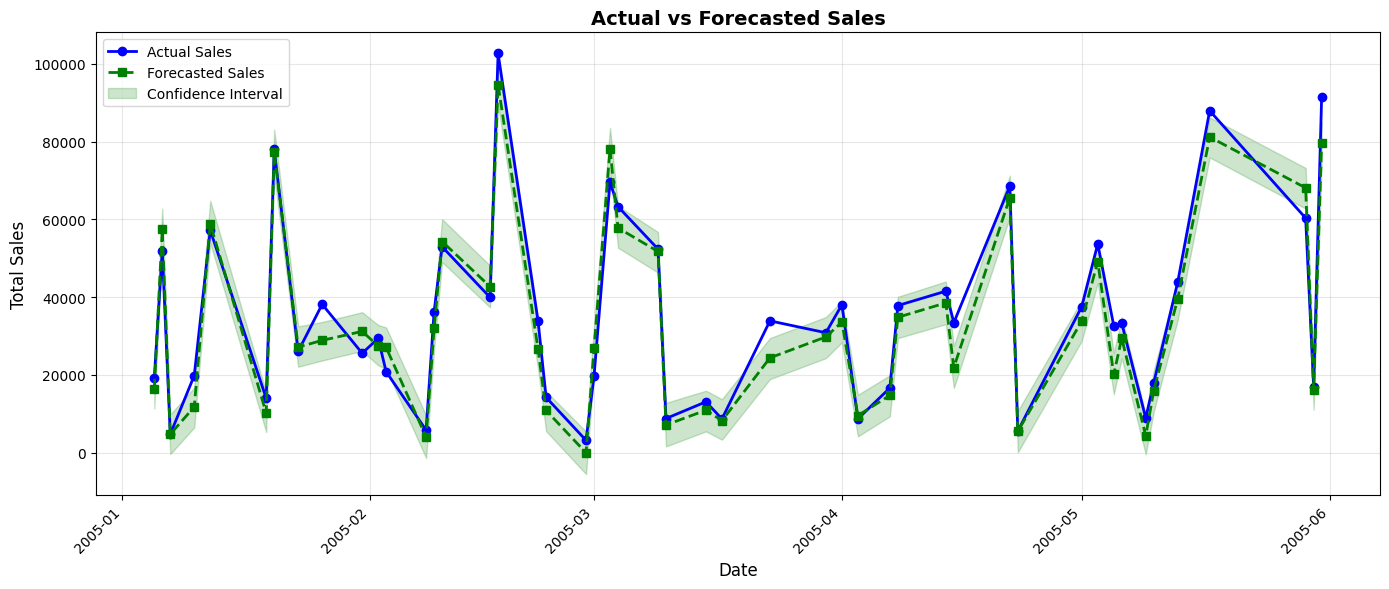

In [121]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(Pmodel_test_subset['ds'], test_subset['total_sales'].values, 
        marker='o', linestyle='-', linewidth=2, markersize=6, 
        label='Actual Sales', color='blue')
ax.plot(Pmodel_test_subset['ds'], forecasting_result['yhat'].values, 
        marker='s', linestyle='--', linewidth=2, markersize=6, 
        label='Forecasted Sales', color='green')
ax.fill_between(Pmodel_test_subset['ds'], 
                forecasting_result['yhat_lower'].values,
                forecasting_result['yhat_upper'].values,
                alpha=0.2, color='green', label='Confidence Interval')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.set_title('Actual vs Forecasted Sales', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()